En este notebook se muestran las correlaciones más destacables entre los vectores económicos y las medidas de centralidad

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import glob
import os
import matplotlib
import matplotlib.pyplot as plt


from scipy.stats import spearmanr

from IPython.display import display

In [2]:
paises_region = ['Argentina', 'Bolivia', 'Brasil', 'Chile', 'Colombia', 'Ecuador',\
          'Paraguay', 'Peru','Sudamerica', 'Uruguay', 'Venezuela']

# Datos

Para correlaciones nuestras variables usaremos datos que ya obtuvimos en notebooks pasados

#### Vectores económicos y medidas de centralidad

In [ ]:
#Introduzca su dirección local
dir_vectores_eco = sorted(glob.glob(\
    r' ... Introduzca dirección local/.../01 - Datos y limpieza/02 - Vectores economicos/*.csv'))

#Introduzca su dirreción local
dir_medidas_centralidad = sorted(glob.glob(\
    r' ... Introduzca dirección local/.../04 - Analisis de redes/01 - Tablas medidas de centralidad/*.csv'))

vectores_eco = dict( (pais, pd.read_csv(df, index_col='Sector')) for pais, df in zip(\
                                                                paises_region, dir_vectores_eco))

medidas_centralidad = dict( (pais, pd.read_csv(df, index_col='Sector')) for pais, df in zip(\
                                                                    paises_region, dir_medidas_centralidad))

#### Grafos

In [ ]:
#Introduzca dirección local
dir_matrices_CT= sorted(glob.glob(\
    r'Introduzca dirección local/.../02 - Redes/01 - Matrices de coeficientes tecnicos/*.csv'))

matrices_CT = dict((pais, pd.read_csv(df)) for pais, df in zip(paises_region, dir_matrices_CT))

for df in matrices_CT.values():
    df.index = df.columns
    
#Creamos a los grafos
grafos= dict((pais ,nx.from_pandas_adjacency(matrices_CT[pais], create_using=nx.DiGraph())) 
             for pais in paises_region)

------

# Correlaciones

A continuación se muestran las correlaciones más destacables

### Correlación: Producción final total y densidades ponderadas

In [5]:
#Produccion final total de todos los grafos
produccion_final_total = [vectores_eco[pais]['Producción Final'].sum() for pais in paises_region]

#Densidades ponderadas de los paises
densidades_ponderadas = [(matrices_CT[pais].to_numpy().sum())/(len(matrices_CT[pais]))**2 
                         for pais in paises_region]

In [6]:
produccion_densidad_df = pd.DataFrame({'Grafo': paises_region,
                                        'Densidad Ponderada' : densidades_ponderadas,
                                         'Producción Final Total' : produccion_final_total})

produccion_densidad_df.round(3)

,Grafo,Densidad Ponderada,Producción Final Total
0,Argentina,0.012,333735.664
1,Bolivia,0.007,16951.830
2,Brasil,0.013,1556124.958
3,Chile,0.012,271019.210
4,Colombia,0.012,254383.225
5,Ecuador,0.011,73360.944
6,Paraguay,0.007,18151.567
7,Peru,0.011,131844.109
8,Sudamerica,0.013,2904780.721
9,Uruguay,0.009,27717.880


Se encontró una fuerte correlación entre ambas variables

In [7]:
#Correlación de densidad ponderada y produccion final total de cada sector
spearmanr(densidades_ponderadas,produccion_final_total)

SpearmanrResult(correlation=0.9545454545454546, pvalue=4.988898739949763e-06)

#### Diagrama de dispersión con escala normal

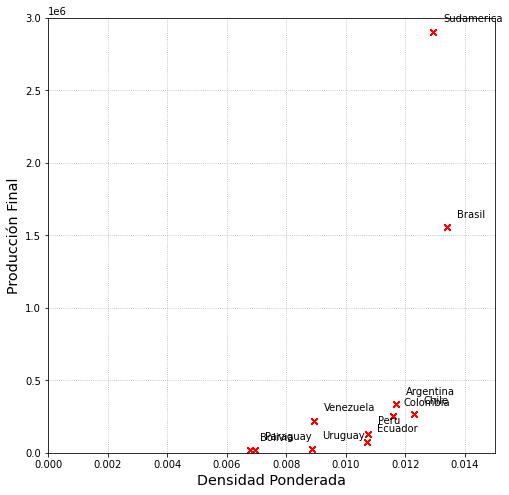

In [8]:
x = densidades_ponderadas
y = produccion_final_total

fig,ax =plt.subplots(figsize=(8,8))
ax.set_ylim(0,3e6)
ax.set_xlim(0,0.015)
ax.set_xlabel('Densidad Ponderada', fontsize='x-large')
ax.set_ylabel('Producción Final', fontsize='x-large')
ax.grid(linestyle=':')

for i, txt in enumerate(paises_region):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='red')

##### Diagrama de dispersión con escala semi logaritmica

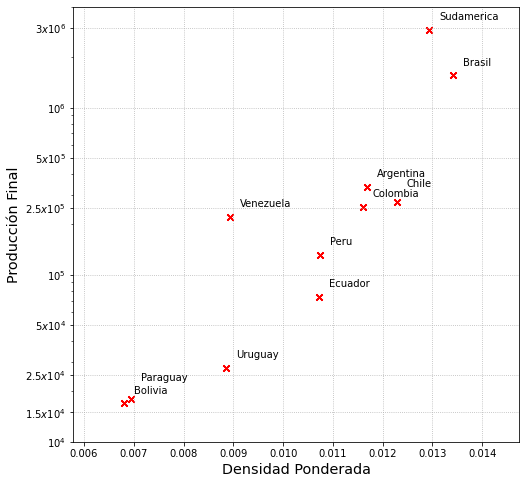

In [9]:
x = densidades_ponderadas
y = produccion_final_total

fig,ax =plt.subplots(figsize=(8,8))
plt.yscale('log')
ax.set_xlabel('Densidad Ponderada', fontsize='x-large')
ax.set_ylabel('Producción Final', fontsize='x-large')
ax.grid(linestyle=':')
ax.set_xlim(min(x)*(1-.15), max(x)*(1+.10))
ax.set_ylim(1*(10**4), 4*(10**6))
ax.set_yticks([10**4, 1.5*(10**4),2.5*(10**4), 5*(10**4),10**5,2.5*(10**5), 5*(10**5),10**6, 3*(10**6)])
ax.set_yticklabels(['$10^4$','$1.5 x 10^4$','$2.5 x 10^4$', '$5 x 10^4$', '$10^5$'
                   ,'$2.5 x 10^5$', '$5 x 10^5$', '$10^6$', '$3 x 10^6$'])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


y_1 = y.copy()
y_1[3] = y_1[3]+ 23000
y_1[6] = y_1[6]+ 2000


for i, txt in enumerate(paises_region):
    ax.annotate(txt, (x[i], y_1[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='red')

-----

### Correlación entre el hub y out degree weighed con la demanda intermedia

In [10]:
outdw = [ medidas_centralidad[pais]['Out degree weighted'] for pais in paises_region]
hub = [ medidas_centralidad[pais]['Hub'] for pais in paises_region]

dem_inter = [ vectores_eco[pais]['Demanda Intermedia'] for pais in paises_region]

Aquí se muestran las correlaciones que hay entre el grado de salida ponderado y hub con la demanda intermedia

Para todos los países son correlaciones fuertes y con bajos P-values

In [11]:
corr_outdw_dem = map(spearmanr, outdw, dem_inter)
corr_hub_dem = map(spearmanr, hub, dem_inter)

r_s_outdw, p_outdw = map(list, zip(*corr_outdw_dem))
r_s_hub, p_hub = map(list, zip(*corr_hub_dem))


df_outdw = pd.DataFrame({'$r_s$': r_s_outdw, 'Valor-$p$': p_outdw})#, index= paises+ ['Sudamérica'])
df_hub = pd.DataFrame({'$r_s$': r_s_hub, 'Valor-$p$': p_hub})#, index= paises+ ['Sudamérica'])


df_juntos = pd.concat([df_outdw,df_hub], keys=['Out degree weighted', 'Hub'], axis=1)

df_juntos.insert(0,'Paises', paises_region)
df_juntos.insert(0,'Vector', ['Demanda Intermedia']*11)
df_juntos.set_index(['Vector','Paises'],inplace=True)

df_juntos

Out degree weighted                     Hub  \
                                            $r_s$     Valor-$p$     $r_s$   
Vector             Paises                                                   
Demanda Intermedia Argentina             0.874672  1.631493e-13  0.787992   
                   Bolivia               0.929765  4.448404e-18  0.918498   
                   Brasil                0.917448  8.592589e-17  0.836023   
                   Chile                 0.929456  4.822608e-18  0.906004   
                   Colombia              0.856473  1.817392e-12  0.845591   
                   Ecuador               0.810319  2.370418e-10  0.806004   
                   Paraguay              0.938028  4.436486e-19  0.914742   
                   Peru                  0.914259  1.716398e-16  0.863415   
                   Sudamerica            0.923077  2.361023e-17  0.863977   
                   Uruguay               0.877815  1.035938e-13  0.898273   
                   Venezuela             0.893236  9.172636e-15  0.858523   

                                             
                                  Valor-$p$  
Vector             Paises                    
Demanda Intermedia Argentina   1.591792e-09  
                   Bolivia     6.801723e-17  
                   Brasil      1.892310e-11  
                   Chile       9.144765e-16  
                   Colombia    6.594090e-12  
                   Ecuador     3.490617e-10  
                   Paraguay    1.548393e-16  
                   Peru        7.549129e-13  
                   Sudamerica  7.015361e-13  
                   Uruguay     3.830915e-15  
                   Venezuela   1.408800e-12

-----

### Correlación entre counting betweenness y demanda intermedia

También hubo correlaciones negativas para la demanda intermedia y la intermediación de conteo en la mayoría de países

In [12]:
count_between = [ medidas_centralidad[pais]['Counting Betweenness'] for pais in paises_region]

dem_inter = [ vectores_eco[pais]['Demanda Intermedia'] for pais in paises_region]

In [13]:
corr_count_between_dem = map(spearmanr, count_between, dem_inter)

r_s_count_between, p_count_between = map(list, zip(*corr_count_between_dem))

df_count_between = pd.DataFrame({'$r_s$': r_s_count_between, 'Valor-$p$': p_count_between})#, index= paises+ ['Sudamérica'])


df_juntos_cb = pd.concat([df_count_between], keys=['Counting Betweenness'], axis=1)

df_juntos_cb.insert(0,'Paises', paises_region)
df_juntos_cb.insert(0,'Vector', ['Demanda Intermedia']*11)
df_juntos_cb.set_index(['Vector','Paises'],inplace=True)
df_juntos_cb.round(3)

Counting Betweenness          
                                             $r_s$ Valor-$p$
Vector             Paises                                   
Demanda Intermedia Argentina                -0.281     0.079
                   Bolivia                   0.492     0.001
                   Brasil                   -0.495     0.001
                   Chile                    -0.263     0.101
                   Colombia                 -0.364     0.021
                   Ecuador                  -0.402     0.010
                   Paraguay                  0.412     0.008
                   Peru                     -0.430     0.006
                   Sudamerica               -0.758     0.000
                   Uruguay                  -0.046     0.778
                   Venezuela                -0.167     0.302

# Tablas de correlación de todos los grafos

Como anexo se agregan todas la matrices de correlación entre los vectores económicos y las medidas de centralidad para todos los grafos

###### Función corr_p_valor

In [8]:
def corr_p_valor(df_medidas, df_vectores):
    '''
    Esta función obtiene la matriz de correlación con el coeficiente de spearman 
    y el valor p asociado entre los dataframes de medidas de centralidad y de los vectores
    
    Parámetros
    ----------
    df_medidas : DataFrame de pandas
        El dataframe que contiene las medidas de centralidadas
        
    df_vectores : DataFrane de pandas
        El dataframe que contiene los vectores económicos
        
    Resultado
    ----------
    df_correlacionado : DataFrame de pandas
        El dataframe con la matriz de correlación
    '''
    
    
    medidas = ['In degree weighted', 'Out degree weighted','Hub', 'Authority', 'Random Walk Centrality', 
            'Counting Betweenness']
    vectores = ['Demanda Intermedia', 'Demanda Final', 'Producción Final','Importaciones', 
            'Exportaciones', 'Valor Agregado']

    #medidas  = df_medidas.columns
    #vectores = df_vectores.columns

    corr_dfs = []

    for medida in medidas:

        r_s = []
        p_values = []

        for vector in vectores:
            tupla = spearmanr(df_medidas[medida],df_vectores[vector])
            r_s.append(tupla[0])
            p_values.append(tupla[1])

        df = pd.DataFrame({'$r_s$': r_s, 'Valor-$p$': p_values}, index= vectores)

        corr_dfs.append(df)
        
    df_correlacionado = pd.concat(corr_dfs, keys = medidas, axis =1)
    
    return df_correlacionado

---

### Tablas con todos los tipos de correlaciones

##### Ejemplo para la matriz regional

In [9]:
corr_p_valor(medidas_centralidad['Sudamerica'],vectores_eco['Sudamerica'])

In degree weighted           Out degree weighted  \
                                $r_s$ Valor-$p$               $r_s$   
Demanda Intermedia          -0.259662  0.105649            0.923077   
Demanda Final               -0.194747  0.228512            0.545403   
Producción Final            -0.237336  0.140318            0.800188   
Importaciones               -0.242964  0.130877            0.687430   
Exportaciones                0.122139  0.452775            0.494934   
Valor Agregado              -0.392871  0.012153            0.772608   

                                       Hub               Authority            \
                       Valor-$p$     $r_s$     Valor-$p$     $r_s$ Valor-$p$   
Demanda Intermedia  2.361023e-17  0.863977  7.015361e-13 -0.103565  0.524813   
Demanda Final       2.731470e-04  0.520638  5.730474e-04 -0.120826  0.457686   
Producción Final    5.793670e-10  0.763977  9.730861e-09 -0.115197  0.479052   
Importaciones       9.590760e-07  0.536210  3.620353e-04 -0.325141  0.040643   
Exportaciones       1.167463e-03  0.452720  3.354508e-03  0.019700  0.903966   
Valor Agregado      5.206505e-09  0.708068  3.212561e-07 -0.180863  0.264060   

                   Random Walk Centrality           Counting Betweenness  \
                                    $r_s$ Valor-$p$                $r_s$   
Demanda Intermedia              -0.521951  0.000552            -0.757786   
Demanda Final                   -0.136961  0.399380            -0.354784   
Producción Final                -0.390994  0.012608            -0.636961   
Importaciones                   -0.308630  0.052666            -0.512758   
Exportaciones                   -0.106379  0.513548            -0.305441   
Valor Agregado                  -0.475797  0.001915            -0.694371   

                                  
                       Valor-$p$  
Demanda Intermedia  1.499880e-08  
Demanda Final       2.468267e-02  
Producción Final    9.913167e-06  
Importaciones       7.170082e-04  
Exportaciones       5.528828e-02  
Valor Agregado      6.705763e-07

#### Ejemplo para todos los países

In [10]:
paises = ['Argentina', 'Bolivia', 'Brasil', 'Chile', 'Colombia', 'Ecuador',\
          'Paraguay', 'Peru', 'Uruguay', 'Venezuela']

for pais in paises:
    print(pais)
    display(corr_p_valor(medidas_centralidad[pais],vectores_eco[pais]))
    print('\n')

Argentina


In degree weighted           Out degree weighted  \
                                $r_s$ Valor-$p$               $r_s$   
Demanda Intermedia           0.023077  0.887600            0.874672   
Demanda Final                0.301876  0.058342            0.485929   
Producción Final             0.143527  0.376940            0.720638   
Importaciones                0.083865  0.606905            0.605441   
Exportaciones                0.061163  0.707724            0.423452   
Valor Agregado              -0.171857  0.288976            0.690056   

                                       Hub               Authority            \
                       Valor-$p$     $r_s$     Valor-$p$     $r_s$ Valor-$p$   
Demanda Intermedia  1.631493e-13  0.787992  1.591792e-09  0.061351  0.706867   
Demanda Final       1.478943e-03  0.545779  2.699772e-04  0.268293  0.094156   
Producción Final    1.574729e-07  0.711445  2.662295e-07  0.183302  0.257564   
Importaciones       3.486559e-05  0.499250  1.039993e-03 -0.040338  0.804809   
Exportaciones       6.476392e-03  0.474296  1.988701e-03  0.068668  0.673740   
Valor Agregado      8.385950e-07  0.613133  2.597268e-05 -0.027017  0.868565   

                   Random Walk Centrality           Counting Betweenness  \
                                    $r_s$ Valor-$p$                $r_s$   
Demanda Intermedia               0.037523  0.818189            -0.281426   
Demanda Final                    0.309193  0.052214             0.062664   
Producción Final                 0.190619  0.238720            -0.111820   
Importaciones                    0.084615  0.603679            -0.168856   
Exportaciones                    0.033021  0.839703            -0.162664   
Valor Agregado                   0.005629  0.972503            -0.228330   

                              
                   Valor-$p$  
Demanda Intermedia  0.078543  
Demanda Final       0.700880  
Producción Final    0.492118  
Importaciones       0.297609  
Exportaciones       0.315931  
Valor Agregado      0.156455



Bolivia


In degree weighted           Out degree weighted  \
                                $r_s$ Valor-$p$               $r_s$   
Demanda Intermedia           0.535248  0.000373            0.929765   
Demanda Final                0.472321  0.002089            0.694510   
Producción Final             0.530494  0.000430            0.788550   
Importaciones                0.388701  0.013185            0.722332   
Exportaciones                0.446801  0.003850            0.708681   
Valor Agregado               0.347908  0.027820            0.803379   

                                       Hub               Authority            \
                       Valor-$p$     $r_s$     Valor-$p$     $r_s$ Valor-$p$   
Demanda Intermedia  4.448404e-18  0.918498  6.801723e-17  0.486530  0.001456   
Demanda Final       6.657488e-07  0.749320  2.655855e-08  0.446801  0.003850   
Producción Final    1.522107e-09  0.822149  7.786199e-11  0.494652  0.001176   
Importaciones       1.426296e-07  0.736976  5.875271e-08  0.366179  0.020134   
Exportaciones       3.105298e-07  0.755232  1.786290e-08  0.474761  0.001966   
Valor Agregado      4.396608e-10  0.811638  2.101862e-10  0.306999  0.053994   

                   Random Walk Centrality           Counting Betweenness  \
                                    $r_s$ Valor-$p$                $r_s$   
Demanda Intermedia               0.532457  0.000405             0.491686   
Demanda Final                    0.552676  0.000217             0.496150   
Producción Final                 0.581597  0.000083             0.519625   
Importaciones                    0.640684  0.000008             0.587904   
Exportaciones                    0.512488  0.000722             0.508920   
Valor Agregado                   0.490892  0.001299             0.412207   

                              
                   Valor-$p$  
Demanda Intermedia  0.001272  
Demanda Final       0.001130  
Producción Final    0.000590  
Importaciones       0.000066  
Exportaciones       0.000798  
Valor Agregado      0.008217



Brasil


In degree weighted           Out degree weighted  \
                                $r_s$ Valor-$p$               $r_s$   
Demanda Intermedia          -0.264916  0.098533            0.917448   
Demanda Final               -0.233583  0.146886            0.516698   
Producción Final            -0.271670  0.089930            0.828143   
Importaciones               -0.240338  0.135222            0.612008   
Exportaciones                0.203002  0.209002            0.483677   
Valor Agregado              -0.384991  0.014165            0.803189   

                                       Hub               Authority            \
                       Valor-$p$     $r_s$     Valor-$p$     $r_s$ Valor-$p$   
Demanda Intermedia  8.592589e-17  0.836023  1.892310e-11 -0.092120  0.571837   
Demanda Final       6.414328e-04  0.481801  1.644767e-03 -0.306004  0.054818   
Producción Final    4.291693e-11  0.739775  4.926243e-08 -0.211257  0.190682   
Importaciones       2.712941e-05  0.424953  6.270093e-03 -0.430394  0.005569   
Exportaciones       1.567461e-03  0.446717  3.857146e-03  0.057974  0.722342   
Valor Agregado      4.469785e-10  0.702439  4.368646e-07 -0.239212  0.137117   

                   Random Walk Centrality           Counting Betweenness  \
                                    $r_s$ Valor-$p$                $r_s$   
Demanda Intermedia              -0.226079  0.160693            -0.494747   
Demanda Final                    0.175797  0.277894            -0.011820   
Producción Final                -0.079550  0.625594            -0.329644   
Importaciones                   -0.128705  0.428657            -0.259099   
Exportaciones                    0.064165  0.694059             0.027392   
Valor Agregado                  -0.140150  0.388386            -0.405253   

                              
                   Valor-$p$  
Demanda Intermedia  0.001173  
Demanda Final       0.942294  
Producción Final    0.037784  
Importaciones       0.106434  
Exportaciones       0.866756  
Valor Agregado      0.009483



Chile


In degree weighted           Out degree weighted  \
                                $r_s$ Valor-$p$               $r_s$   
Demanda Intermedia          -0.149531  0.357092            0.929456   
Demanda Final                0.008068  0.960595            0.604878   
Producción Final            -0.103752  0.524058            0.836585   
Importaciones               -0.210694  0.191894            0.609006   
Exportaciones                0.192683  0.233578            0.554409   
Valor Agregado              -0.016793  0.918086            0.659693   

                                       Hub               Authority            \
                       Valor-$p$     $r_s$     Valor-$p$     $r_s$ Valor-$p$   
Demanda Intermedia  4.822608e-18  0.906004  9.144765e-16  0.073546  0.651984   
Demanda Final       3.561427e-05  0.612383  2.673872e-05  0.113133  0.487015   
Producción Final    1.781873e-11  0.818949  1.060579e-10  0.081989  0.615001   
Importaciones       3.044740e-05  0.608068  3.155769e-05 -0.010694  0.947781   
Exportaciones       2.056195e-04  0.592120  5.703829e-05  0.270544  0.091322   
Valor Agregado      3.654061e-06  0.834748  2.166463e-11  0.215489  0.181744   

                   Random Walk Centrality           Counting Betweenness  \
                                    $r_s$ Valor-$p$                $r_s$   
Demanda Intermedia              -0.209233  0.195066            -0.263089   
Demanda Final                    0.084256  0.605223             0.067367   
Producción Final                -0.067180  0.680432            -0.121223   
Importaciones                   -0.180334  0.265483            -0.224245   
Exportaciones                    0.067930  0.677054             0.091387   
Valor Agregado                   0.004316  0.978912            -0.024208   

                              
                   Valor-$p$  
Demanda Intermedia  0.100964  
Demanda Final       0.679587  
Producción Final    0.456195  
Importaciones       0.164206  
Exportaciones       0.574914  
Valor Agregado      0.882127



Colombia


In degree weighted           Out degree weighted  \
                                $r_s$ Valor-$p$               $r_s$   
Demanda Intermedia          -0.293996  0.065568            0.856473   
Demanda Final               -0.108068  0.506848            0.446154   
Producción Final            -0.224015  0.164650            0.690432   
Importaciones               -0.004128  0.979834            0.435647   
Exportaciones               -0.080863  0.619881            0.484240   
Valor Agregado              -0.487054  0.001436            0.734897   

                                       Hub               Authority            \
                       Valor-$p$     $r_s$     Valor-$p$     $r_s$ Valor-$p$   
Demanda Intermedia  1.817392e-12  0.845591  6.594090e-12 -0.057974  0.722342   
Demanda Final       3.907472e-03  0.464916  2.506597e-03  0.127017  0.434789   
Producción Final    8.225725e-07  0.681051  1.321206e-06 -0.003940  0.980750   
Importaciones       4.957724e-03  0.468856  2.276200e-03  0.203940  0.206861   
Exportaciones       1.544903e-03  0.437148  4.794116e-03 -0.005253  0.974335   
Valor Agregado      6.686940e-08  0.651407  5.307862e-06 -0.237148  0.140641   

                   Random Walk Centrality           Counting Betweenness  \
                                    $r_s$ Valor-$p$                $r_s$   
Demanda Intermedia               0.080113  0.623143            -0.363602   
Demanda Final                    0.352533  0.025676             0.004690   
Producción Final                 0.227205  0.158564            -0.196811   
Importaciones                    0.443715  0.004132             0.095872   
Exportaciones                    0.052533  0.747503            -0.166229   
Valor Agregado                   0.100563  0.536961            -0.296435   

                              
                   Valor-$p$  
Demanda Intermedia  0.021096  
Demanda Final       0.977084  
Producción Final    0.223522  
Importaciones       0.556209  
Exportaciones       0.305297  
Valor Agregado      0.063260



Ecuador


In degree weighted           Out degree weighted  \
                                $r_s$ Valor-$p$               $r_s$   
Demanda Intermedia          -0.184615  0.254111            0.810319   
Demanda Final                0.063977  0.694910            0.311820   
Producción Final            -0.015760  0.923108            0.589681   
Importaciones               -0.309944  0.051616            0.464540   
Exportaciones               -0.076923  0.637086            0.384615   
Valor Agregado              -0.100563  0.536961            0.601689   

                                       Hub               Authority            \
                       Valor-$p$     $r_s$     Valor-$p$     $r_s$ Valor-$p$   
Demanda Intermedia  2.370418e-10  0.806004  3.490617e-10 -0.172233  0.287909   
Demanda Final       5.014437e-02  0.358724  2.302186e-02 -0.004128  0.979834   
Producción Final    6.227174e-05  0.615947  2.327493e-05 -0.072233  0.657815   
Importaciones       2.529571e-03  0.387805  1.341582e-02 -0.281614  0.078336   
Exportaciones       1.426698e-02  0.366979  1.984267e-02 -0.026829  0.869470   
Valor Agregado      4.014035e-05  0.619325  2.037625e-05 -0.099250  0.542318   

                   Random Walk Centrality           Counting Betweenness  \
                                    $r_s$ Valor-$p$                $r_s$   
Demanda Intermedia              -0.277674  0.082781            -0.402251   
Demanda Final                    0.097936  0.547700             0.003940   
Producción Final                -0.078987  0.628050            -0.178799   
Importaciones                   -0.115197  0.479052            -0.242777   
Exportaciones                   -0.079550  0.625594            -0.080488   
Valor Agregado                  -0.141088  0.385186            -0.237148   

                              
                   Valor-$p$  
Demanda Intermedia  0.010079  
Demanda Final       0.980750  
Producción Final    0.269640  
Importaciones       0.131184  
Exportaciones       0.621511  
Valor Agregado      0.140641



Paraguay


In degree weighted           Out degree weighted  \
                                $r_s$ Valor-$p$               $r_s$   
Demanda Intermedia           0.514742  0.000678            0.938028   
Demanda Final                0.503099  0.000937            0.626291   
Producción Final             0.493521  0.001212            0.756244   
Importaciones                0.332926  0.035805            0.592767   
Exportaciones                0.304046  0.056468            0.220501   
Valor Agregado               0.296338  0.063350            0.728826   

                                       Hub               Authority            \
                       Valor-$p$     $r_s$     Valor-$p$     $r_s$ Valor-$p$   
Demanda Intermedia  4.436486e-19  0.914742  1.548393e-16  0.534272  0.000384   
Demanda Final       1.541049e-05  0.668920  2.378316e-06  0.494272  0.001188   
Producción Final    1.667221e-08  0.767512  7.556583e-09  0.489765  0.001338   
Importaciones       5.571967e-05  0.538657  3.361488e-04  0.375951  0.016813   
Exportaciones       1.715477e-01  0.286023  7.358394e-02  0.366376  0.020062   
Valor Agregado      9.692148e-08  0.670798  2.175271e-06  0.303099  0.057280   

                   Random Walk Centrality           Counting Betweenness  \
                                    $r_s$ Valor-$p$                $r_s$   
Demanda Intermedia               0.521690  0.000556             0.412207   
Demanda Final                    0.581596  0.000083             0.485634   
Producción Final                 0.595681  0.000050             0.475493   
Importaciones                    0.434195  0.005121             0.322781   
Exportaciones                    0.258049  0.107910             0.268938   
Valor Agregado                   0.468545  0.002294             0.324131   

                              
                   Valor-$p$  
Demanda Intermedia  0.008217  
Demanda Final       0.001490  
Producción Final    0.001930  
Importaciones       0.042210  
Exportaciones       0.093336  
Valor Agregado      0.041307



Peru


In degree weighted           Out degree weighted  \
                                $r_s$ Valor-$p$               $r_s$   
Demanda Intermedia          -0.276548  0.084087            0.914259   
Demanda Final                0.088180  0.588458            0.632083   
Producción Final            -0.066041  0.685566            0.764165   
Importaciones               -0.213884  0.185098            0.727580   
Exportaciones                0.092683  0.569480            0.686679   
Valor Agregado              -0.115009  0.479773            0.760788   

                                       Hub               Authority            \
                       Valor-$p$     $r_s$     Valor-$p$     $r_s$ Valor-$p$   
Demanda Intermedia  1.716398e-16  0.863415  7.549129e-13 -0.204128  0.206434   
Demanda Final       1.215360e-05  0.614259  2.486110e-05  0.043902  0.787939   
Producción Final    9.602156e-09  0.727392  1.056525e-07 -0.084991  0.602069   
Importaciones       1.044702e-07  0.710319  2.835186e-07 -0.084053  0.606097   
Exportaciones       9.963230e-07  0.615947  2.327493e-05 -0.023265  0.886692   
Valor Agregado      1.218012e-08  0.691182  7.913721e-07 -0.138837  0.392891   

                   Random Walk Centrality           Counting Betweenness  \
                                    $r_s$ Valor-$p$                $r_s$   
Demanda Intermedia              -0.360976  0.022115            -0.429644   
Demanda Final                   -0.115385  0.478331            -0.087617   
Producción Final                -0.223640  0.165377            -0.255910   
Importaciones                   -0.150281  0.354656            -0.252345   
Exportaciones                   -0.272045  0.089470            -0.185366   
Valor Agregado                  -0.226454  0.159981            -0.245216   

                              
                   Valor-$p$  
Demanda Intermedia  0.005662  
Demanda Final       0.590850  
Producción Final    0.110967  
Importaciones       0.116204  
Exportaciones       0.252152  
Valor Agregado      0.127236



Uruguay


In degree weighted           Out degree weighted  \
                                $r_s$ Valor-$p$               $r_s$   
Demanda Intermedia          -0.008820  0.956923            0.877815   
Demanda Final                0.030866  0.850040            0.645742   
Producción Final             0.086593  0.595212            0.766033   
Importaciones               -0.052444  0.747916            0.715365   
Exportaciones                0.130682  0.421541            0.489022   
Valor Agregado               0.001595  0.992207            0.764344   

                                       Hub               Authority            \
                       Valor-$p$     $r_s$     Valor-$p$     $r_s$ Valor-$p$   
Demanda Intermedia  1.035938e-13  0.898273  3.830915e-15  0.136242  0.401881   
Demanda Final       6.807386e-06  0.718930  1.738747e-07  0.248522  0.122026   
Producción Final    8.404246e-09  0.830401  3.408430e-11  0.270100  0.091875   
Importaciones       2.133492e-07  0.660192  3.571494e-06  0.198049  0.220564   
Exportaciones       1.364528e-03  0.588853  6.414422e-05  0.467283  0.002366   
Valor Agregado      9.480665e-09  0.832465  2.752963e-11  0.203865  0.207031   

                   Random Walk Centrality           Counting Betweenness  \
                                    $r_s$ Valor-$p$                $r_s$   
Demanda Intermedia              -0.009197  0.955086            -0.045983   
Demanda Final                    0.006380  0.968831             0.038471   
Producción Final                 0.040722  0.802983             0.060239   
Importaciones                   -0.042787  0.793209             0.002440   
Exportaciones                    0.044098  0.787014             0.043535   
Valor Agregado                   0.018954  0.907586             0.012010   

                              
                   Valor-$p$  
Demanda Intermedia  0.778134  
Demanda Final       0.813680  
Producción Final    0.711948  
Importaciones       0.988080  
Exportaciones       0.789672  
Valor Agregado      0.941365



Venezuela


In degree weighted           Out degree weighted  \
                                $r_s$ Valor-$p$               $r_s$   
Demanda Intermedia           0.071958  0.659037            0.893236   
Demanda Final                0.004409  0.978457            0.627920   
Producción Final             0.040435  0.804345            0.715733   
Importaciones               -0.126184  0.437830            0.575758   
Exportaciones                0.267836  0.094739            0.261457   
Valor Agregado              -0.026550  0.870815            0.758326   

                                       Hub               Authority            \
                       Valor-$p$     $r_s$     Valor-$p$     $r_s$ Valor-$p$   
Demanda Intermedia  9.172636e-15  0.858523  1.408800e-12  0.171967  0.288663   
Demanda Final       1.442197e-05  0.655315  4.457267e-06  0.056384  0.729664   
Producción Final    2.089161e-07  0.741627  4.378905e-08  0.113613  0.485158   
Importaciones       1.014320e-04  0.563749  1.518378e-04 -0.031804  0.845536   
Exportaciones       1.031752e-01  0.135185  4.055791e-01  0.146630  0.366603   
Valor Agregado      1.445055e-08  0.738812  5.235210e-08  0.079651  0.625153   

                   Random Walk Centrality           Counting Betweenness  \
                                    $r_s$ Valor-$p$                $r_s$   
Demanda Intermedia               0.064265  0.693606            -0.167276   
Demanda Final                   -0.077212  0.635819            -0.205554   
Producción Final                -0.066704  0.682574            -0.232573   
Importaciones                   -0.133690  0.410839            -0.333896   
Exportaciones                    0.071579  0.660722            -0.022421   
Valor Agregado                  -0.043813  0.788362            -0.253401   

                              
                   Valor-$p$  
Demanda Intermedia  0.302216  
Demanda Final       0.203212  
Producción Final    0.148691  
Importaciones       0.035236  
Exportaciones       0.890774  
Valor Agregado      0.114634

#### Exportando las tablas

In [12]:
try:
    #os.mkdir('01 - Correlaciones de los grafos')
    
    for pais in paises_region:      
        corr_p_valor(medidas_centralidad[pais],vectores_eco[pais]).to_csv(
        r'01 - Correlaciones de los paises/'+pais+'_Correlación_MedidasVectores.csv')

except:
    print('La carpeta y los documentos ya fueron creados')

-----

# Información del notebook

In [18]:
import session_info
session_info.show(cpu=True, html=False)

-----
matplotlib          3.5.1
networkx            2.4
numpy               1.21.2
pandas              1.3.3
scipy               1.4.1
session_info        1.0.0
-----
IPython             7.20.0
jupyter_client      6.1.11
jupyter_core        4.7.1
notebook            6.2.0
-----
Python 3.8.10 (default, Mar 13 2023, 10:26:41) [GCC 9.4.0]
Linux-5.15.0-67-generic-x86_64-with-glibc2.29
4 logical CPU cores, x86_64
-----
Session information updated at 2023-03-27 18:44
